# Hypothesis Testing

## Getting Started
### Libraries to Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats

### Read in Data

This is a fairly common dataset, here sourced from [data.world](https://data.world/data-society/capital-bikeshare-2011-2012), but also available from the UCI database.

In [2]:
df = pd.read_csv('Data/bike_data.csv')

## Data Cleaning

Our date column was an object, so transform to a datetime with pandas and create a new column for Month.

In [3]:
df.Date = pd.to_datetime(arg=df.Date) #dtype('<M8[ns]')
df['Month'] = df['Date'].dt.month

In [4]:
df.sample(5)

,Date,Season,Hour,Holiday,Day of the Week,Working Day,Weather Type,Temperature F,Temperature Feels F,Humidity,Wind Speed,Casual Users,Registered Users,Total Users,Month
10471,2012-03-17,1,10,0,6,0,2,59.0,60.8,77,6,140,303,443,3
459,2011-01-21,4,4,0,5,1,2,34.9,33.8,87,6,0,1,1,1
424,2011-01-19,4,17,0,3,1,1,47.0,42.8,57,22,7,190,197,1
3746,2011-06-10,2,0,0,5,1,3,76.3,80.6,65,15,8,61,69,6
12129,2012-05-25,1,14,0,5,1,1,79.8,84.2,58,9,104,263,367,5


## Hypothesis Testing

### Do users ride more during comfortable temperatures?

Thanks to Matt Wilkins for his bike riding expertise. 

In [5]:
df['Comfortable Temp?'] = np.where((df['Temperature Feels F'] > 50) & (df['Temperature Feels F'] < 85), 1, 0)

#### Let's Start with some Visualization

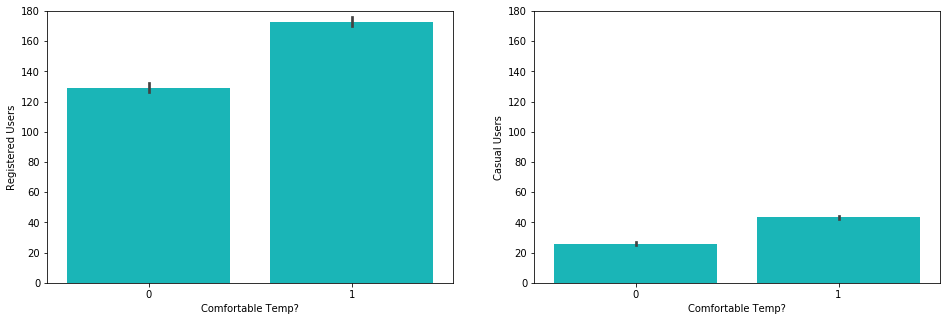

In [6]:
fig, ax = plt.subplots(1,2)
sns.barplot(data=df, x='Comfortable Temp?', y='Registered Users', ax=ax[0], color = 'darkturquoise')
sns.barplot(data=df, x='Comfortable Temp?', y='Casual Users', ax=ax[1], color = 'darkturquoise')
ax[0].set(ylim=(0, 180))
ax[1].set(ylim=(0, 180))
fig.set_figheight(5)
fig.set_figwidth(16)
plt.show()

In [7]:
comfy_registered = df[df['Comfortable Temp?'] == 1]['Registered Users']
noncomfy_registered = df[df['Comfortable Temp?'] == 0]['Registered Users']

In [8]:
scipy.stats.ttest_ind(comfy_registered, noncomfy_registered)

Ttest_indResult(statistic=19.141783708515234, pvalue=7.6926513295976845e-81)

With a p-value significantly lower than 0.05, we can conclude that these means are statistically different and that temperature does affect the level of registered ridership.

In [9]:
comfy_casual = df[df['Comfortable Temp?'] == 1]['Casual Users']
noncomfy_casual = df[df['Comfortable Temp?'] == 0]['Casual Users']

In [10]:
scipy.stats.ttest_ind(comfy_casual, noncomfy_casual)

Ttest_indResult(statistic=23.30627567580721, pvalue=2.4872749610746814e-118)

With a p-value significantly lower than 0.05, we can conclude that these means are statistically different and that temperature does affect the level of casual ridership.

### Does Weather Type affect ridership of registered users?

How much does a bad weather day affect that day's rides/revenue?

In [11]:
df_good = df[df['Weather Type'] == 1]['Registered Users'].mean()
df_okay = df[df['Weather Type'] == 2]['Registered Users'].mean()
df_poor = df[df['Weather Type'] == 3]['Registered Users'].mean()
df_bad = df[df['Weather Type'] == 4]['Registered Users'].mean()

[df_good, df_okay, df_poor, df_bad]

[164.3238412336809, 145.57020246478874, 95.52360817477097, 71.66666666666667]

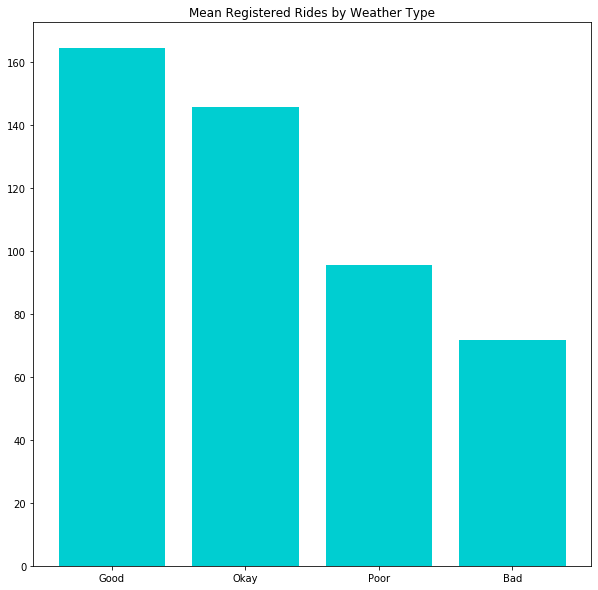

In [12]:
x = ['Good', 'Okay', 'Poor', 'Bad']
y = [df_good, df_okay, df_poor, df_bad]

plt.figure(figsize=(10,10))
plt.bar(x, y, color = 'darkturquoise')
plt.title('Mean Registered Rides by Weather Type')
plt.show()

In [13]:
scipy.stats.f_oneway(df[df['Weather Type'] == 1]['Registered Users'],
df[df['Weather Type'] == 2]['Registered Users'],
df[df['Weather Type'] == 3]['Registered Users'],
df[df['Weather Type'] == 4]['Registered Users'])

F_onewayResult(statistic=94.79420665557402, pvalue=7.480328863758025e-61)

The F-stat and p-value are both significant, thus we can reject our null hypothesis that ridership is equal among all weather types (RegisteredUsers<sub>Good</sub> = RegisteredUsers<sub>Okay</sub> = RegisteredUsers<sub>Poor</sub> = RegisteredUsers<sub>Bad</sub>). We can conclude that there is a statistically significant difference between the groups, but without further ad-hoc tests we cannot conclude which group(s) is different.

### Are there more riders in 2011 or 2012?

Is our market share growing?

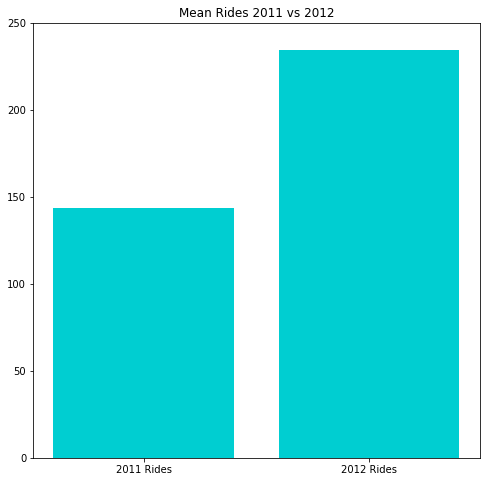

In [14]:
df_2011 = df.loc[df['Date'].dt.year == 2011]
df_2012 = df.loc[df['Date'].dt.year == 2012]
total_2011 = df_2011['Total Users'].mean()
total_2012 = df_2012['Total Users'].mean()

plt.figure(figsize=(8,8))
plt.bar(x = ['2011 Rides', '2012 Rides'], height = [total_2011, total_2012], color = 'darkturquoise')
plt.title('Mean Rides 2011 vs 2012')
plt.ylim(0, 250)
plt.show()

In [15]:
scipy.stats.ttest_ind(df_2011['Total Users'], df_2012['Total Users'])

Ttest_indResult(statistic=-34.10813930288585, pvalue=7.213184208684302e-247)

Our T-Test reports a statistically significant difference between the two populations, and we can therefore reject our null hypothesis that the two years have the same mean. 

### Percentage of rides that are rush hour commutes? 

Idea is to say, here is when you should ride for less congestion.

Looking at commutes 7-8am and 5-6pm.

In [16]:
df_7a = df[df.Hour == 7]
df_8a = df[df.Hour == 8]
df_5p = df[df.Hour == 17]
df_6p = df[df.Hour == 18]

In [17]:
df_commute = pd.concat([df_7a, df_8a, df_5p, df_6p])

In [18]:
commute_riders = df_commute['Total Users'].sum()

In [19]:
non_commute_riders = df['Total Users'].sum() - commute_riders

In [20]:
x = ['Commuter Rides', 'Non-Commuter Rides']
y = [commute_riders, non_commute_riders]

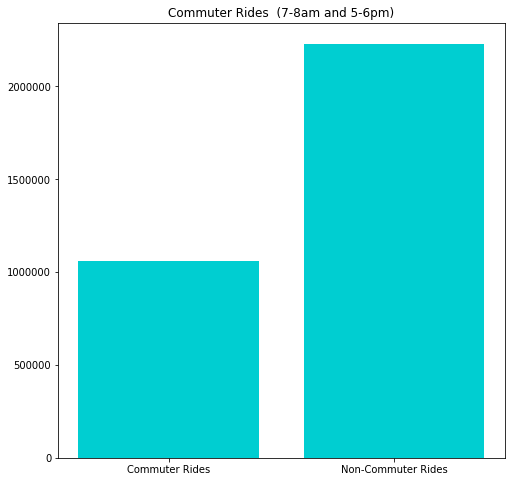

In [21]:
plt.figure(figsize=(8,8))
plt.bar(x, y, color ='darkturquoise')
plt.title('Commuter Rides  (7-8am and 5-6pm)')
plt.show()

If we open up the commuter hours by an hour on each side, 7-9am and 5-7pm.

In [22]:
df_7a = df[df.Hour == 7]
df_8a = df[df.Hour == 8]
df_9a = df[df.Hour == 9]
df_5p = df[df.Hour == 17]
df_6p = df[df.Hour == 18]
df_7p = df[df.Hour == 19]

In [23]:
df_commute = pd.concat([df_7a, df_8a, df_9a, df_5p, df_6p, df_7p])

In [24]:
commute_riders = df_commute['Total Users'].sum()

In [25]:
non_commute_riders = df['Total Users'].sum() - commute_riders

In [26]:
x = ['Commuter Rides', 'Non-Commuter Rides']
y = [commute_riders, non_commute_riders]

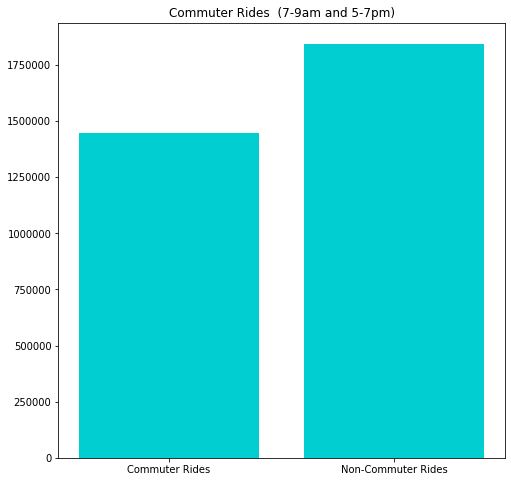

In [27]:
plt.figure(figsize=(8,8))
plt.bar(x, y, color ='darkturquoise')
plt.title('Commuter Rides  (7-9am and 5-7pm)')
plt.show()

In [28]:
commute_riders/(commute_riders + non_commute_riders)*100

43.97729022476834

Increasing the window of commuter times to 7-9am and 5-7pm shows that about 45% of total rides are commuters.

### Do more riders ride in the morning or evening? 

Do people bike into work but not out, or vice versa, what are the pain points driving this behavior?

In [29]:
morning_rides = pd.concat([df_7a, df_8a, df_9a])['Registered Users'].sum()
evening_rides = pd.concat([df_5p, df_6p, df_7p])['Registered Users'].sum()

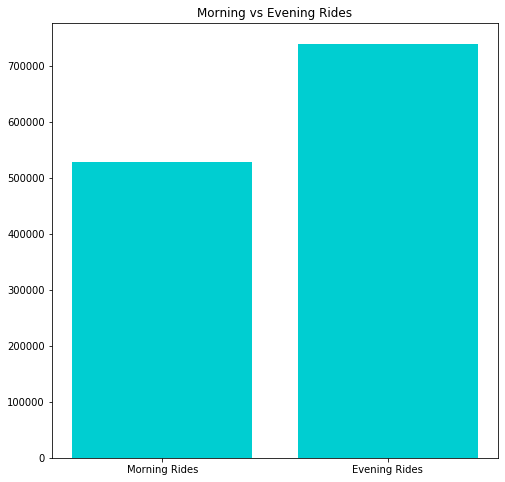

In [30]:
plt.figure(figsize=(8,8))
plt.bar(x = ['Morning Rides', 'Evening Rides'], height = [morning_rides, evening_rides], color = 'darkturquoise')
plt.title('Morning vs Evening Rides')
plt.show()

In [31]:
scipy.stats.ttest_ind(pd.concat([df_7a, df_8a, df_9a])['Registered Users'], pd.concat([df_5p, df_6p, df_7p])['Registered Users'])

Ttest_indResult(statistic=-16.84093083280438, pvalue=1.0452334780454361e-61)

There is a statistically significant difference between the number of morning rides and evening rides (p-value = 1.04e-61). If registered riders are full-time bike commuters, why are morning and evening rides not more similar? Is there a pain point here about bike availability in residential areas compared to the business center, aka bikes are becoming clustered downtown as people bike in? We would really need some GIS data to identify where bikes are located at specific hours. 

### Look into what is counted as a holiday here...

In [32]:
df[df.Holiday == 1]['Date'].value_counts()

2012-04-16    24
2012-07-04    24
2011-10-10    24
2012-05-28    24
2011-11-24    24
2011-04-15    24
2011-05-30    24
2012-01-16    24
2012-09-03    24
2012-11-12    24
2011-01-17    24
2011-09-05    24
2011-11-11    24
2011-07-04    24
2012-10-08    24
2012-11-22    24
2011-02-21    24
2011-12-26    23
2012-01-02    23
2012-12-25    23
2012-02-20    23
Name: Date, dtype: int64

- Martin Luther King, Jr. Day
- President's Day
- Easter
- Memorial Day
- Independence Day
- Labor Day
- Columbus Day
- Veterans' Day
- Thanksgiving
- Christmas
- New Years